# Deep Learning Evaluation (Machine Learning TU Vienna 2018)

This notebook is used to evaluate Deep Learning for 2 different datasets:
    1. http://data.vicos.si/datasets/FIDS30/FIDS30.zip
    2. http://l2r.cs.uiuc.edu/~cogcomp/Data/Car/CarData.tar.gz
    
To run this notebook without the requirement of setting up all dependencies you can simply use following docker image:
https://cloud.docker.com/u/freecraver/repository/docker/freecraver/keras

A lot of hyperparameters can be changed within the `config.py` file. Their effects and default values are described there.

Make sure to place this notebook in a shared folder and pass it as volume to the docker container at creation.
Example command (host path assuming Windows OS): `docker run -it -v //D//your//folder//here:/tf/notebooks -p 8888:8888 --name mlex_group8 freecraver/keras`

For GPU support you may substitute `freecraver/keras` with `tensorflow/tensorflow:latest-gpu-py3-jupyter` and install following modules manually via `pip install`:
* keras
* Pillow _(Image processing)_
* sklearn _(Evaluation, Preprocessing)_
* pandas _(Evaluation)_
* requests _(only if dataset not present)_

You still require an NVIDIA docker driver (https://github.com/NVIDIA/nvidia-docker). As the setup for such can be a cumbersome task, the default uses only CPU. Keep in mind that this leads to a major performance loss. (On a side note the tensorflow gpu image also has twice the size of the cpu one..)

Recommend Min. Resource Requirements (for Docker):
* 6 GB RAM

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from tensorflow import set_random_seed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import requests
import zipfile
import tarfile
import io

import os
import glob
import time

import gc

# custom .py files
from image_preprocessing import resize_and_crop
import config as cfg

car_dir = 'res/car'
fruit_dir = 'res/fruit'

# create directories if they are not present already
if not os.path.exists(car_dir):
    os.makedirs(car_dir)
if not os.path.exists(fruit_dir):
    os.makedirs(fruit_dir)    

## Fetch datasets

This may take a while for the fruits dataset (450MB)

__NOTE: if you already have the data on your local machine simply copy it into the shared folder to sapre the time required for download. Use the following paths:__  
`res/car/` containing the extracted `CarData` folder  
`res/fruit/` containing the extracted `FIDS30` folder

In [2]:
fruit_url = 'http://data.vicos.si/datasets/FIDS30/FIDS30.zip'
car_url = 'http://l2r.cs.uiuc.edu/~cogcomp/Data/Car/CarData.tar.gz'

car_data_path = os.path.join(car_dir,'CarData')
fruits_data_path = os.path.join(fruit_dir, 'FIDS30')

if os.path.exists(car_data_path):
    print("Using local car data")
else:
    print("Fetching car data...")
    r = requests.get(car_url)
    t = tarfile.open(fileobj=io.BytesIO(r.content))
    t.extractall(path=car_dir)
    t.close()

if os.path.exists(fruits_data_path):
    print("Using local fruits data")
else:
    print("Fetching fruit data...")
    r = requests.get(fruit_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=fruit_dir)

print("Finished fetching datasets")

Using local car data
Using local fruits data
Finished fetching datasets


## Retrieve images

**IMPORTANT NOTE: If your kernel crashes at this point, you may have to increase the amount of alllocated RAM for your docker container**

Also the dataset contains many files that are no common JPEGs (i.e. alpha channel, etc.) -> those images are converted to 3-channel JPEGs, for three images this does not work:
* bananas_51.jpg
* peaches_18.jpg
* tomatoes_38.jpg

Those 3 files are ignored


In [3]:
def resize_images(images, identifier, target_height = None, target_width = None, use_cropping=False):
    """
    used to resize all images to the mean height/width
    note that this is prone to generating distorted images
    better results are expected with methods like pyramid pooling (https://arxiv.org/abs/1406.4729)
    """
    if target_height is None or target_width is None:
        target_size = cfg.TARGET_SIZE
        mean_shape = np.mean([[i.shape[0],i.shape[1]] for i in images], axis=0)
        max_v = max(mean_shape[0], mean_shape[1])
        # scale by preserving average ratio
        target_height = int(target_size * mean_shape[0]/max_v)
        target_width = int(target_size * mean_shape[1]/max_v)
    
    print("Resizing to {}x{} images".format(target_width, target_height))
    
    for i in range(len(images)):
        if target_height != images[i].shape[0] or target_width != images[i].shape[1]:
            # only resize image if it has not already the correct size
            if use_cropping:
                # use scaling and cropping
                images[i] = np.array(resize_and_crop(Image.fromarray(images[i]), target_width, target_height))
            else:
                # only scale
                images[i] = np.array(Image.fromarray(images[i]).resize((target_width, target_height), Image.ANTIALIAS))
        print("Resized {} {} images".format(i+1, identifier), end="\r")
    
    print("Resized {} {} images".format(len(images), identifier))
    
    return images

def get_car_images(folder = 'TrainImages'):
    files = glob.glob(os.path.join(car_data_path,folder, '*.pgm'))
    print("Found {} car files".format(len(files)))
    images = []
    image_names = []

    for filename in files:
        image_names.append(os.path.basename(filename))
        with Image.open(filename) as img:
            images.append(np.array(img))
    
    images = np.stack(resize_images(images,
                                    'car',
                                    target_width=cfg.TARGET_WIDTH_CAR,
                                    target_height=cfg.TARGET_HEIGHT_CAR,
                                    use_cropping=cfg.USE_CROPPING_CAR),
                      axis=0)
    
    return images, image_names

def get_fruit_images():
    images = []
    image_names = []
    cnt=0
    
    for dirpath, dirnames, filenames in os.walk(fruits_data_path):
        for filename in [f for f in filenames if f.endswith(".jpg")]:
            cnt = cnt+1
            with Image.open(os.path.join(dirpath,filename)) as img:
                if img.format != "JPEG":
                    # we only want 3 channels
                    img = img.convert("RGB")
                np_img = np.array(img)
                if len(np_img.shape) != 3 or np_img.shape[2] != 3:
                    # incorrectly imported/converted RGB file
                    continue
                images.append(np_img)
                image_names.append(os.path.split(dirpath)[-1] + "_" + filename)
                print("Found {} fruit files".format(len(image_names)), end="\r")
    
    print("Found {} fruit files".format(len(image_names)))
    
    images = np.stack(resize_images(images,
                                    'fruit',
                                    target_width=cfg.TARGET_WIDTH_FRUIT,
                                    target_height=cfg.TARGET_HEIGHT_FRUIT,
                                    use_cropping=cfg.USE_CROPPING_FRUIT),
                      axis=0)
    
    return images, image_names
    

car_images, car_img_names = get_car_images()
print("-"*60)
fruit_images, fruit_img_names = get_fruit_images() 

Found 1050 car files
Resizing to 100x40 images
Resized 1050 car images
------------------------------------------------------------
Found 968 fruit files
Resizing to 200x156 images
Resized 968 fruit images


## Check import images

figs_11.jpg


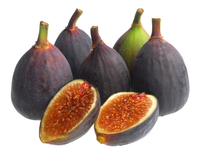

In [4]:
print(fruit_img_names[321])
Image.fromarray(fruit_images[321])

## Ground truth setup

While the goal of the car use case is to predict if a car is present or not (binary), the goal of the fruit dataset is to predict which out of $n$ fruits is present in a picture (n-ary)

In [5]:
cls_car = [0 if name.startswith('neg') else 1 for name in car_img_names]
cls_fruit = [name.split('_')[0] for name in fruit_img_names]

print("{} unique classes for cars".format(len(set(cls_car))))
print("{} unique classes for fruits".format(len(set(cls_fruit))))

2 unique classes for cars
30 unique classes for fruits


### Transform labels

(only for fruits): as wee need numeric target values we transfrom the target labels

In [6]:
cls_cat = pd.Series(cls_fruit).astype('category').cat
cls_fruit_c = cls_cat.codes

## Train/test split

We split the fruits in a stratified fashion (i.e. preserving class label distribution) and load the test data for the car dataset

In [7]:
car_images_train = car_images
cls_car_train = cls_car
car_images_test, car_img_names_t = get_car_images('TestImages')
cls_car_test = [1 for name in car_img_names_t] # only pos

fruit_images_train, fruit_images_test, cls_fruit_train, cls_fruit_test = train_test_split(fruit_images, cls_fruit_c, test_size=0.2, random_state=9253, stratify=cls_fruit_c)

Found 170 car files
Resizing to 100x40 images
Resized 170 car images


## Baseline values

Show how good a dumb classifier that always predicts the most common class is

In [8]:
def print_baseline_stats(cls):
    max_cnt = 0
    for v in set(cls):
        max_cnt = max(max_cnt, cls.count(v))
        print("Class {}: {}".format(v, cls.count(v)))

    print("Baseline accuracy: {}".format(max_cnt/len(cls)))
    
print("-"*20, "\nCar Baseline")
print_baseline_stats(cls_car_train)

print("-"*20, "\nFruits Baseline")
print_baseline_stats(pd.Categorical.from_codes(cls_fruit_train, categories=cls_cat.categories).astype(str).tolist())

-------------------- 
Car Baseline
Class 0: 500
Class 1: 550
Baseline accuracy: 0.5238095238095238
-------------------- 
Fruits Baseline
Class bananas: 33
Class acerolas: 19
Class plums: 25
Class blackberries: 29
Class apricots: 24
Class limes: 23
Class grapes: 30
Class pineapples: 27
Class oranges: 28
Class peaches: 21
Class grapefruits: 25
Class pomegranates: 24
Class passionfruit: 18
Class strawberries: 37
Class cherries: 26
Class guava: 26
Class lemons: 23
Class tomatoes: 36
Class watermelons: 25
Class blueberries: 26
Class olives: 18
Class cantaloupes: 25
Class apples: 30
Class avocados: 21
Class pears: 26
Class mangos: 27
Class raspberries: 31
Class kiwifruit: 29
Class figs: 21
Class coconuts: 21
Baseline accuracy: 0.04780361757105943


## Standardization

For the fruits dataset each color-channel is standardized independently, for the car dataset we only have grayscale images (i.e. 1 single channel)

In [9]:
car_scaling = {'mean': car_images_train.mean(), 'std': car_images_train.std()}
fruit_scaling = {'mean': fruit_images_train.mean(axis=(0,1,2), keepdims=True), 
                 'std': fruit_images_train.std(axis=(0,1,2), keepdims=True)}
print(car_scaling)
print(fruit_scaling)

car_images_train = (car_images_train - car_scaling.get('mean')) / car_scaling.get('std')
fruit_images_train = (fruit_images_train - fruit_scaling.get('mean')) / fruit_scaling.get('std')
car_images_test = (car_images_test - car_scaling.get('mean')) / car_scaling.get('std')
fruit_images_test = (fruit_images_test - fruit_scaling.get('mean')) / fruit_scaling.get('std')
print("Car Min-Max", car_images_train.min(),car_images_train.max())
print("Fruit Min-Max", fruit_images_train.min(axis=(0,1,2)), fruit_images_train.max(axis=(0,1,2)))

{'mean': 129.58246809523808, 'std': 74.27669459504543}
{'mean': array([[[[181.13993093, 150.25755694, 119.42136967]]]]), 'std': array([[[[74.5967228 , 85.5621107 , 96.07639164]]]])}
Car Min-Max -1.744591204572555 1.6885179475006928
Fruit Min-Max [-2.42825588 -1.75612261 -1.2429835 ] [0.99012485 1.22416853 1.41115448]


### Adapt shape for Keras model

Convert single channel (grayscale) array to a 4dim array for compliance reasons

In [10]:
car_images_train = car_images_train.reshape(car_images_train.shape[0], car_images_train.shape[1], car_images_train.shape[2], 1)
car_images_test = car_images_test.reshape(car_images_test.shape[0], car_images_test.shape[1], car_images_test.shape[2], 1)
print("Car-Shape", car_images_train.shape)
print("Fruit-Shape", fruit_images_train.shape)

Car-Shape (1050, 40, 100, 1)
Fruit-Shape (774, 156, 200, 3)


## Create the CNN model

We use the same model baseline for both datasets (i.e. the only difference is that the fruits dataset has 3 color channels)

In [31]:
def create_model(input_shape, n_classes=1, n_filters =16, kernel_size=3, activation="softmax"):
    model = Sequential()
    
    # Layer 1
    model.add(Conv2D(n_filters, kernel_size, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  # ReLu activation
    model.add(MaxPooling2D(pool_size=(2, 2))) # reducing image resolution by half
    model.add(Dropout(0.3))  # random "deletion" of %-portion of units in each batch

    # Layer 2
    model.add(Conv2D(n_filters, kernel_size))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Flatten()) # Note: Keras does automatic shape inference.
    
    # Full Layer
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    model.add(Dense(n_classes,activation=activation))
    
    return model

car_model = create_model(car_images_train.shape[1:],
                         kernel_size=cfg.KERNEL_SIZE_CAR,
                         activation='sigmoid')
fruit_model = create_model(fruit_images_train.shape[1:],
                           kernel_size=cfg.KERNEL_SIZE_FRUIT,
                           n_classes=len(cls_cat.categories))

### Car model summary

In [32]:
car_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 36, 96, 16)        416       
_________________________________________________________________
batch_normalization_3 (Batch (None, 36, 96, 16)        64        
_________________________________________________________________
activation_7 (Activation)    (None, 36, 96, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 48, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 18, 48, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 44, 16)        6416      
_________________________________________________________________
activation_8 (Activation)    (None, 14, 44, 16)        0         
__________

### Fruit model summary

In [33]:
fruit_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 152, 196, 16)      1216      
_________________________________________________________________
batch_normalization_4 (Batch (None, 152, 196, 16)      64        
_________________________________________________________________
activation_10 (Activation)   (None, 152, 196, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 76, 98, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 76, 98, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 94, 16)        6416      
_________________________________________________________________
activation_11 (Activation)   (None, 72, 94, 16)        0         
__________

# Car CNN
From this point on the two models will be handled separately (to save mem usage and for a clearer picture

## Train model

We decided to use 10% of training data as validation data  
**Very important** -  Keras does not randomly select observations (i.e. takes the last 10%) - see for reference: https://keras.io/getting-started/faq/#how-is-the-validation-split-computed  
That problem actually cost us a lot of time, as this is also done wrong in the tutorial. We get a very high validation set accuracy as we only select observations from one target class. 
This is a good example for the rule of always shuffling training data and also for using stratified sampling!

In [17]:
# important step
car_images_train, car_images_val, cls_car_train, cls_car_val = train_test_split(car_images_train, cls_car_train, test_size=0.1, stratify=cls_car_train, random_state=9253)

In [34]:
set_random_seed(9253)
start_time = time.time()
car_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
car_history = car_model.fit(car_images_train,
                            np.array(cls_car_train),
                            batch_size=32,
                            epochs=cfg.EPOCHS_CAR,
                            validation_data=(car_images_val, cls_car_val))
print("Training took {} seconds".format(time.time()-start_time))


Train on 945 samples, validate on 105 samples
Epoch 1/15
945/945 [==============================] - 7s 7ms/step - loss: 0.6950 - acc: 0.7206 - val_loss: 0.3162 - val_acc: 0.8857
Epoch 2/15
945/945 [==============================] - 6s 6ms/step - loss: 0.2119 - acc: 0.9164 - val_loss: 0.1580 - val_acc: 0.9333
Epoch 3/15
945/945 [==============================] - 6s 7ms/step - loss: 0.1278 - acc: 0.9608 - val_loss: 0.1082 - val_acc: 0.9810
Epoch 4/15
945/945 [==============================] - 6s 7ms/step - loss: 0.0853 - acc: 0.9661 - val_loss: 0.1121 - val_acc: 0.9524
Epoch 5/15
945/945 [==============================] - 6s 7ms/step - loss: 0.0589 - acc: 0.9788 - val_loss: 0.0995 - val_acc: 0.9714
Epoch 6/15
945/945 [==============================] - 6s 6ms/step - loss: 0.0573 - acc: 0.9799 - val_loss: 0.0802 - val_acc: 0.9905
Epoch 7/15
945/945 [==============================] - 6s 6ms/step - loss: 0.0319 - acc: 0.9905 - val_loss: 0.1175 - val_acc: 0.9810
Epoch 8/15
945/945 [==========

## Evaluation on test set

In [21]:
def plot_confusion_matrix(y_actual, y_pred, categories, title='Confusion matrix', cmap=plt.cm.binary, size=(6,4)):
    s_actual = pd.Categorical(y_actual, categories=categories)
    s_pred = pd.Categorical(y_pred, categories=categories)
    df_confusion = pd.crosstab(s_actual, s_pred, dropna=False)
    plt.figure(figsize=size)
    plt.matshow(df_confusion, cmap=cmap, fignum=1)
    plt.title(title, y=1.1)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=90)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    
def plot_training_curve(hist):  
    colors = {'loss':'r', 'acc':'b', 'val_loss':'m', 'val_acc':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve") 
    plt.xlabel("Epoch")

    for measure in hist.keys():
        color = colors[measure]
        plt.plot(hist[measure], color + '-', label=measure)  # use last 2 values to draw line

    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

In [35]:
start_time = time.time()
car_pred = car_model.predict_classes(car_images_test)
print("Prediction took {} seconds".format(time.time()-start_time))
pd.Series(car_pred.flatten()).value_counts()

Prediction took 0.4412972927093506 seconds


0    159
1     11
dtype: int64

ACC: 0.06470588235294118


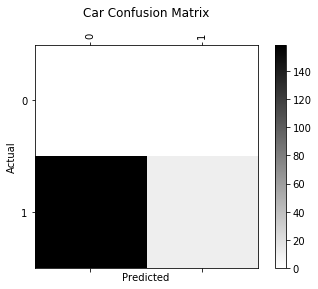

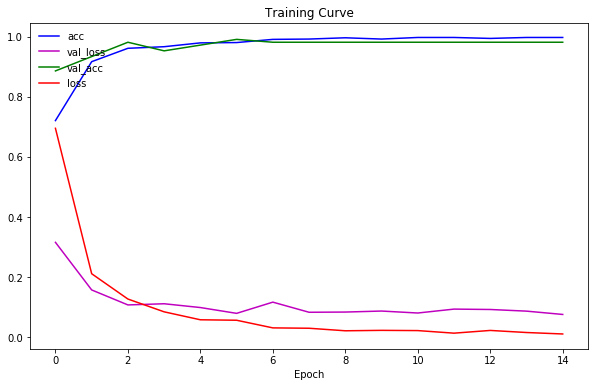

In [36]:
print("ACC:", accuracy_score(car_pred, cls_car_test))
plot_confusion_matrix(cls_car_test, car_pred.flatten(), [0,1], title='Car Confusion Matrix')
plot_training_curve(car_history.history)

### Data augmenation

From the learning curve we can observe that we probably have an overfitting classifier. Interestingly the accuracy is very high also for the validation set, but extremely low for the test set. This indicates a major difference between validation and test set. We suspect the cause of the issue to lie within the cars in the test set's pictures being a lot smaller compared to the validation set.  
To improve the results we add more images that should help the model to generalize better.

In [37]:
car_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [38]:
# use same training/val/test splits as w/o data augmentation
set_random_seed(9253)
start_time = time.time()
car_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
car_history = car_model.fit_generator(car_datagen.flow(car_images_train,
                                                       np.array(cls_car_train),
                                                       batch_size=16),
                                      steps_per_epoch =len(car_images_train)/16,
                                      epochs=cfg.EPOCHS_CAR,
                                      validation_data=(car_images_val, cls_car_val))
print("Training took {} seconds".format(time.time()-start_time))

Epoch 1/15
60/59 [==============================] - 9s 146ms/step - loss: 0.6335 - acc: 0.7450 - val_loss: 0.8893 - val_acc: 0.5619
Epoch 2/15
60/59 [==============================] - 7s 120ms/step - loss: 0.4701 - acc: 0.7604 - val_loss: 0.2155 - val_acc: 0.9143
Epoch 3/15
60/59 [==============================] - 8s 125ms/step - loss: 0.3841 - acc: 0.8333 - val_loss: 0.5196 - val_acc: 0.7810
Epoch 4/15
60/59 [==============================] - 7s 124ms/step - loss: 0.3447 - acc: 0.8520 - val_loss: 0.3586 - val_acc: 0.8857
Epoch 5/15
60/59 [==============================] - 7s 119ms/step - loss: 0.3555 - acc: 0.8325 - val_loss: 2.5518 - val_acc: 0.5333
Epoch 6/15
60/59 [==============================] - 7s 123ms/step - loss: 0.4466 - acc: 0.8356 - val_loss: 2.0668 - val_acc: 0.5333
Epoch 7/15
60/59 [==============================] - 7s 122ms/step - loss: 0.3598 - acc: 0.8552 - val_loss: 0.7509 - val_acc: 0.7429
Epoch 8/15
60/59 [==============================] - 7s 123ms/step - loss: 0.

In [39]:
start_time = time.time()
car_pred = car_model.predict_classes(car_images_test)
print("Prediction took {} seconds".format(time.time()-start_time))
pd.Series(car_pred.flatten()).value_counts()

Prediction took 0.5196781158447266 seconds


1    159
0     11
dtype: int64

ACC: 0.9352941176470588


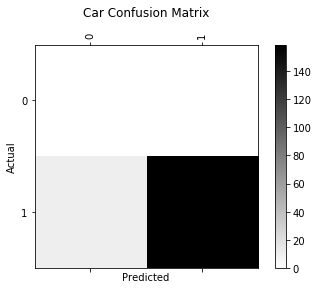

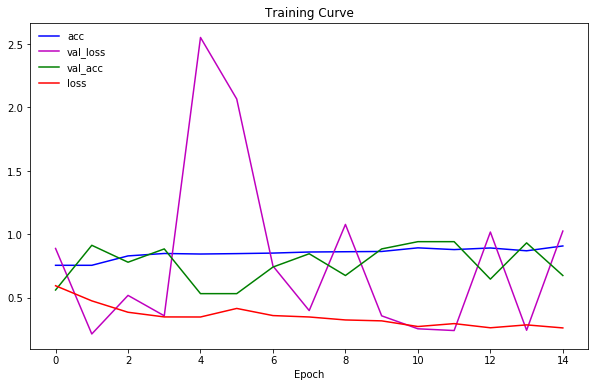

In [40]:
print("ACC:", accuracy_score(car_pred, cls_car_test))
plot_confusion_matrix(cls_car_test, car_pred.flatten(), [0,1], title='Car Confusion Matrix')
plot_training_curve(car_history.history)

# Fruit CNN

## Train model

we create a stratified validation set (see explanation at car CNN section) and transform all target labels to the Keras' required format. Note that this code only works, if all classes are present in train, val and test sets (if not, you have to adapt the  `num_classes` parameter of `to_categorical` along with some tweeks

In [27]:
# important step
fruit_images_train, fruit_images_val, cls_fruit_train, cls_fruit_val = train_test_split(fruit_images_train, cls_fruit_train, test_size=0.1, stratify=cls_fruit_train, random_state=9253)

# convert to categorical
cls_fruit_train = to_categorical(cls_fruit_train)
cls_fruit_val = to_categorical(cls_fruit_val)

In [62]:
set_random_seed(9253)
start_time = time.time()
fruit_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
fruit_history = fruit_model.fit(fruit_images_train,
                                cls_fruit_train,
                                batch_size=32,
                                epochs=cfg.EPOCHS_FRUIT,
                                validation_data=(fruit_images_val, cls_fruit_val))
print("Training took {} seconds".format(time.time()-start_time))

Train on 696 samples, validate on 78 samples
Epoch 1/15
696/696 [==============================] - 56s 81ms/step - loss: 3.5160 - acc: 0.0618 - val_loss: 3.0580 - val_acc: 0.0769
Epoch 2/15
696/696 [==============================] - 57s 81ms/step - loss: 2.9242 - acc: 0.1739 - val_loss: 2.8235 - val_acc: 0.1282
Epoch 3/15
696/696 [==============================] - 54s 77ms/step - loss: 2.6309 - acc: 0.2385 - val_loss: 2.7042 - val_acc: 0.2051
Epoch 4/15
696/696 [==============================] - 53s 76ms/step - loss: 2.1580 - acc: 0.3477 - val_loss: 2.5240 - val_acc: 0.2564
Epoch 5/15
696/696 [==============================] - 59s 84ms/step - loss: 1.6894 - acc: 0.4756 - val_loss: 2.6917 - val_acc: 0.2692
Epoch 6/15
696/696 [==============================] - 54s 77ms/step - loss: 1.4601 - acc: 0.5718 - val_loss: 3.4281 - val_acc: 0.2564
Epoch 7/15
696/696 [==============================] - 51s 74ms/step - loss: 1.0623 - acc: 0.6968 - val_loss: 2.6749 - val_acc: 0.2564
Epoch 8/15
696/69

## Evaluation on test set

In [63]:
start_time = time.time()
fruit_pred = fruit_model.predict_classes(fruit_images_test)
print("Prediction took {} seconds".format(time.time()-start_time))
pd.Series([cls_cat.categories[i] for i in fruit_pred]).value_counts()

Prediction took 5.436249494552612 seconds


blackberries    23
kiwifruit       14
guava           12
cherries        10
oranges          9
cantaloupes      9
plums            8
limes            8
bananas          8
grapes           8
blueberries      7
lemons           6
acerolas         6
pineapples       6
mangos           6
apricots         6
strawberries     6
tomatoes         5
avocados         5
raspberries      5
coconuts         4
apples           4
pears            3
figs             3
watermelons      3
grapefruits      3
olives           2
pomegranates     2
peaches          2
passionfruit     1
dtype: int64

ACC: 0.29381443298969073


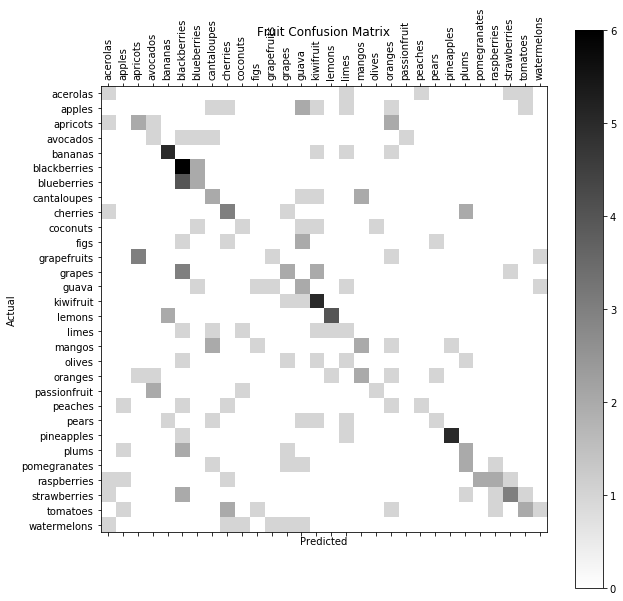

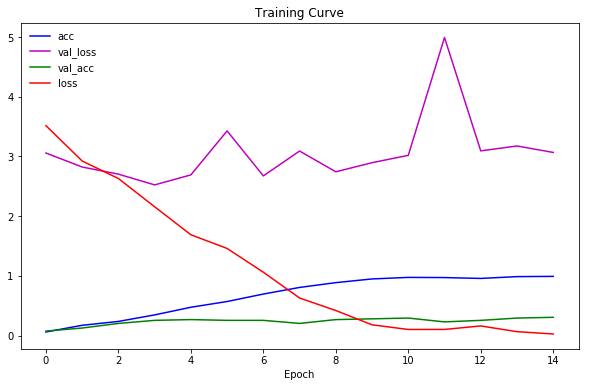

In [64]:
print("ACC:", accuracy_score(fruit_pred, cls_fruit_test))
plot_confusion_matrix([cls_cat.categories[i] for i in cls_fruit_test],
                      [cls_cat.categories[i] for i in fruit_pred],
                      cls_cat.categories,
                      title='Fruit Confusion Matrix',
                      size= (10,10))
plot_training_curve(fruit_history.history)

### Data augmentation

While the signs of overfitting are not as obvious as for the car dataset, we still expect improvements from using the data generator

In [65]:
fruit_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [66]:
# use same training/val/test splits as w/o data augmentation
set_random_seed(9253)
start_time = time.time()
fruit_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
fruit_history = fruit_model.fit_generator(fruit_datagen.flow(fruit_images_train,
                                                       np.array(cls_fruit_train),
                                                       batch_size=16),
                                      steps_per_epoch =len(fruit_images_train)/16,
                                      epochs=cfg.EPOCHS_FRUIT,
                                      validation_data=(fruit_images_val, cls_fruit_val))
print("Training took {} seconds".format(time.time()-start_time))

Epoch 1/15
44/43 [==============================] - 62s 1s/step - loss: 3.0825 - acc: 0.1762 - val_loss: 2.7910 - val_acc: 0.1538
Epoch 2/15
44/43 [==============================] - 64s 1s/step - loss: 2.6059 - acc: 0.2017 - val_loss: 2.8035 - val_acc: 0.1795
Epoch 3/15
44/43 [==============================] - 70s 2s/step - loss: 2.5189 - acc: 0.2173 - val_loss: 2.2082 - val_acc: 0.3974
Epoch 4/15
44/43 [==============================] - 64s 1s/step - loss: 2.3772 - acc: 0.2713 - val_loss: 2.1598 - val_acc: 0.2308
Epoch 5/15
44/43 [==============================] - 63s 1s/step - loss: 2.3710 - acc: 0.2529 - val_loss: 1.9794 - val_acc: 0.3205
Epoch 6/15
44/43 [==============================] - 75s 2s/step - loss: 2.2819 - acc: 0.2798 - val_loss: 2.6009 - val_acc: 0.2821
Epoch 7/15
44/43 [==============================] - 61s 1s/step - loss: 2.1987 - acc: 0.2969 - val_loss: 1.9364 - val_acc: 0.3333
Epoch 8/15
44/43 [==============================] - 67s 2s/step - loss: 2.1740 - acc: 0.31

In [67]:
start_time = time.time()
fruit_pred = fruit_model.predict_classes(fruit_images_test)
print("Prediction took {} seconds".format(time.time()-start_time))
pd.Series([cls_cat.categories[i] for i in fruit_pred]).value_counts()

Prediction took 5.388756036758423 seconds


strawberries    37
kiwifruit       16
lemons          13
blackberries    13
bananas         11
cherries        10
coconuts        10
pears            9
grapes           9
plums            7
pineapples       7
oranges          6
guava            6
mangos           4
passionfruit     4
figs             4
olives           4
apricots         4
peaches          3
grapefruits      3
limes            3
blueberries      3
cantaloupes      2
avocados         2
tomatoes         2
apples           1
pomegranates     1
dtype: int64

ACC: 0.36597938144329895


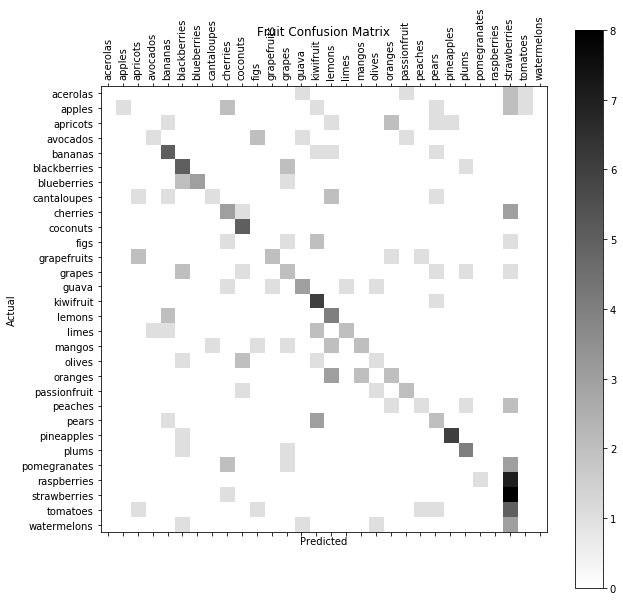

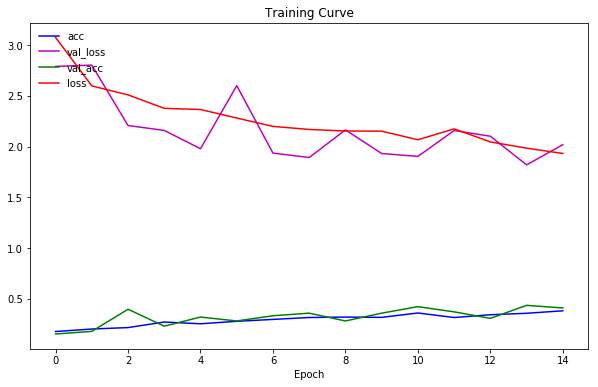

In [68]:
print("ACC:", accuracy_score(fruit_pred, cls_fruit_test))
plot_confusion_matrix([cls_cat.categories[i] for i in cls_fruit_test],
                      [cls_cat.categories[i] for i in fruit_pred],
                      cls_cat.categories,
                      title='Fruit Confusion Matrix',
                      size= (10,10))
plot_training_curve(fruit_history.history)

# Results

In [ ]:
car_accuracy_wo_augmentation_scale_only = 0.02353
car_accuracy_wo_augmentation_scale_crop = 0.05294
car_accuracy_augmentation = 0.60588
fruit_accuracy_wo_augmentation_scale_only = 0.34536
fruit_accuracy_wo_augmentation_scale_crop = 0.30928
fruit_accuracy_augmentation =  0.34021

## Helpful utilities

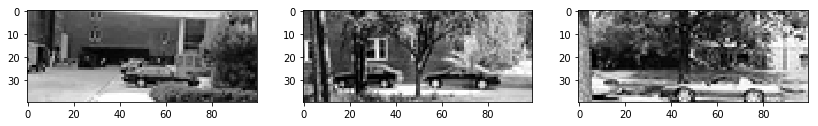

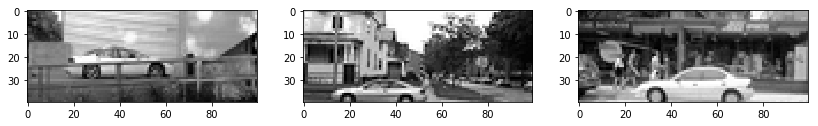

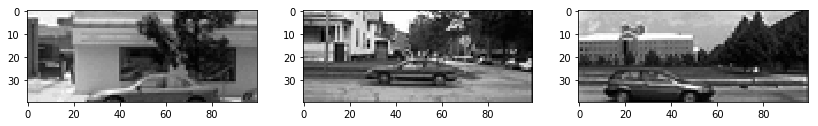

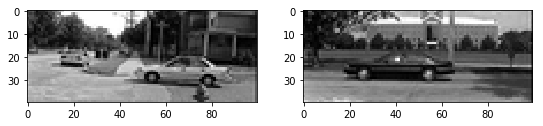

In [61]:
def show_wrong_predictions(predict, actual, images, scaling):
    wrong_indices = np.where(predict != actual)[0]
    col = 0
    img_per_col = 3
    for idx in wrong_indices:
        if col%img_per_col == 0:
            f= plt.figure(figsize=(14,14))
        f.add_subplot(1,img_per_col, col+1)
        plt.imshow(Image.fromarray((images[idx]*scaling.get('std')+scaling.get('mean')).astype('uint8').reshape(40,100)))
        col = (col+1)%img_per_col
    
show_wrong_predictions(car_pred.flatten() ,cls_car_test, car_images_test, car_scaling)

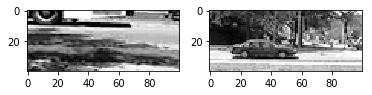

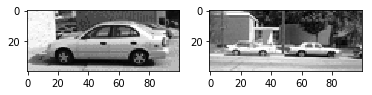

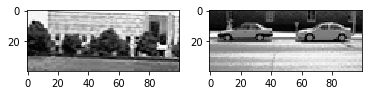

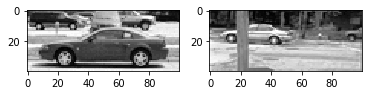

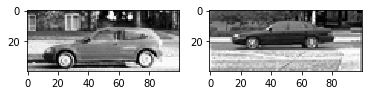

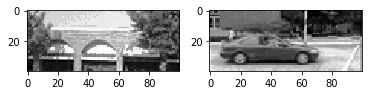

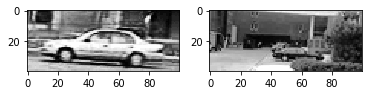

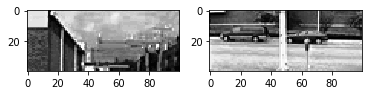

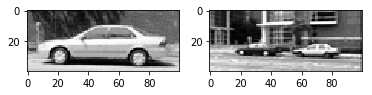

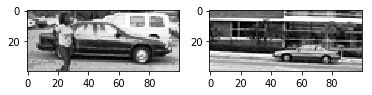

In [34]:
# recreate image be reverting standardization
for i in range(10):
    f= plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(Image.fromarray((car_images_train[i]*car_scaling.get('std')+car_scaling.get('mean')).astype('uint8').reshape(40,100)))
    f.add_subplot(1,2, 2)
    plt.imshow(Image.fromarray((car_images_test[i]*car_scaling.get('std')+car_scaling.get('mean')).astype('uint8').reshape(40,100)))